## Sentiment Analysis Using Naive Bayes

In [206]:
#load necessary libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read Dataset
df=pd.read_csv("sentiment.csv")
df.head()

,Phrase,label
0,Spider-man is better than any summer blockbust...,Positive
1,of good sense,Positive
2,", then knock yourself out and enjoy the big sc...",Negative
3,So could young romantics out on a date .,Positive
4,humour,Positive


In [3]:
df.shape

(2800, 2)

In [4]:
len(df[df['label']=='Positive']) #total number of positive class

1800

In [5]:
len(df[df['label']=='Negative']) #total number of negative class

1000

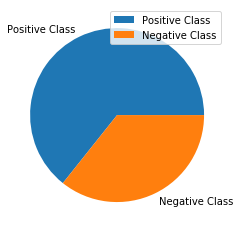

In [6]:
plt.pie(x=[len(df[df['label']=='Positive']),len(df[df['label']=='Negative'])],labels=["Positive Class","Negative Class"])
plt.legend()
plt.show()

The number of positive class is quite larger than number of negative class examples. 

## Data Cleaning 

In [69]:
new_df=df.copy()

**Clean comma, dot, exclamation symbols from the dataset**

In [70]:
import re
def clean_phrase(dataset):
    return re.sub("[^a-z\s']+"," ",dataset, flags=re.IGNORECASE)
new_df['Phrase']=new_df['Phrase'].apply(clean_phrase)

**Encode Labels- Positive =1 and Negative = 0**

In [71]:
def encode_labels(dataset):
    if dataset=="Positive":
        dataset=1
    elif dataset=="Negative":
        dataset=0
    return dataset 

new_df['label']=new_df['label'].apply(encode_labels)

In [72]:
new_df.head()

,Phrase,label
0,Spider man is better than any summer blockbust...,1
1,of good sense,1
2,then knock yourself out and enjoy the big sc...,0
3,So could young romantics out on a date,1
4,humour,1


**Split dataset into train, val and test set**

In [73]:
total_len=len(new_df)
train_len=int(0.6*total_len)
test_len=int(0.4*total_len)
print("total=> {} train_len=> {} test_len =>{}".format(total_len,train_len,test_len))

total=> 2800 train_len=> 1680 test_len =>1120


In [74]:
train_df=new_df[0:train_len]
test_df=new_df[train_len:]

In [75]:
print("Length of train dataset and test dataset")
print("train_df_len=> {} test_df_len =>{}".format(len(train_df),len(test_df)))

Length of train dataset and test dataset
train_df_len=> 1680 test_df_len =>1120


In [76]:
vocab=list()
#create a corpus of vocab
for i in train_df.Phrase.tolist():
    vocab.extend(i.split(" "))
    
#take unique words from vocab   
unique_vocab=list(set(vocab)) #set can't be indexed so change it to list for simplicity    

In [77]:
print("Vocab Length => {} Unique Vocab Length => {}".format(len(vocab),len(unique_vocab)))

Vocab Length => 15136 Unique Vocab Length => 1842


**Calculating Class Priors**


In [224]:
class_priors=train_df['label'].value_counts(normalize=True)#.to_dict()
class_priors

1    0.646429
0    0.353571
Name: label, dtype: float64

*Get Class 0 [Negative] words from Phrases*

In [225]:
class_0_words=[]
for sentence in train_df[train_df['label']==0]['Phrase']:
    word_list=sentence.lower().split(" ")
    new_word_list=[]
    for w in word_list:
        if w!='':
            new_word_list.append(w)   
    class_0_words.extend(new_word_list)

*Get Class 1 [Positive] words from Phrases*

In [226]:
class_1_words=[]
for sentence in train_df[train_df['label']==1]['Phrase']:
    word_list=sentence.lower().split(" ")
    new_word_list=[]
    for w in word_list:
        if w!='':
            new_word_list.append(w)   
    class_1_words.extend(new_word_list)

In [227]:
class_words={
    0:class_0_words,
    1:class_1_words
}

**Count occurence of word and find word probabilities for respective classes**



P(Class | Text) = P(Text | Class) * P(Class) 
                = P(W1|Class)P(W2|Class)P(W3|Class)...P(Wn|Class)* P(Class)
                
                
Also perform laplacian smoothing.                

In [228]:
def count_occurence(word,word_list):
    count=0
    for w in word_list:
        if word==w:
            count+=1
    return count   

def get_word_probs_with_laplacian_smoothing(class_0_words,class_1_words,alpha,unique_vocab):
    word_probs={
        0:{},
        1:{}
    }
    #Laplacian Smoothing 
    for word in unique_vocab:
        word_probs[0][word]=((count_occurence(word,class_0_words) + alpha)/(len(class_0_words)+alpha*len(unique_vocab)))
        word_probs[1][word]=((count_occurence(word,class_1_words) + alpha)/(len(class_1_words)+alpha*len(unique_vocab)))
    
    return word_probs


## PREDICTION

In [344]:
def predict(alpha,dataset): 
    word_probs=get_word_probs_with_laplacian_smoothing(class_0_words,class_1_words,alpha,unique_vocab)
    predicted_class=[]
    for phrase in dataset:
        phraseArr=phrase.split(" ")
        prob_0_given_string=1
        prob_1_given_string=1
        for w in phraseArr:
            try:
                prob_0_given_string=prob_0_given_string*word_probs[0][w]
                prob_1_given_string=prob_1_given_string*word_probs[1][w]
            except Exception:
                w_prob_class_0=((alpha/len(class_0_words)+alpha*len(unique_vocab)))
                prob_0_given_string=prob_0_given_string*w_prob_class_0
                w_prob_class_1=((alpha/len(class_1_words)+alpha*len(unique_vocab)))
                prob_1_given_string=prob_1_given_string*w_prob_class_1
            prob_0_given_string*=class_priors[0]
            prob_1_given_string*=class_priors[1]
           
        if prob_1_given_string>prob_0_given_string:
            predicted_class.append(1)
        else:
            predicted_class.append(0)    
    
    return predicted_class

In [349]:
predictions=predict(1,test_df["Phrase"])

In [350]:
##confusion matrix
def get_confusion_matrix(actual,predicted):
    confusion_matrix=np.zeros((2,2))
    for x,y in zip(actual,predicted):
        confusion_matrix[x,y] +=1
    return confusion_matrix

In [351]:
confusion_matrix=get_confusion_matrix(test_df['label'],predictions)
confusion_matrix

array([[233., 173.],
       [ 29., 685.]])

In [352]:
##accuracy
accuracy=(confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix)
accuracy

0.8196428571428571

In [353]:
##Recall= TP/(TP+FN)
recall=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
recall

0.5738916256157636

In [354]:
##Precision= TP/(TP+FP) is fraction of +ve examples classifier classified as +ve that are actually +ve
precision=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[1][0])
precision

0.8893129770992366

In [355]:
##F1-Score
f1_score=(2*recall*precision)/(recall+precision)
f1_score

0.6976047904191617

**ROC Curve**

ROC(Receiver Operating Characteristics) Curve is a TPR vs FPR plot at different threshold levels 

*Treating alpha as a hyperparameter, ROC plot is shown for Naive Bayes analysis. Alpha is varied from 1 to 100*

In [356]:
TPR=[]
FPR=[]
for alpha in np.arange(1,100,1):
    predictions=predict(alpha,test_df["Phrase"])
    confusion_matrix=get_confusion_matrix(test_df["label"],predictions)
    true_pos_rate=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
    false_pos_rate=(confusion_matrix[1][0])/(confusion_matrix[1][0]+confusion_matrix[1][1])
    TPR.append(true_pos_rate)
    FPR.append(false_pos_rate)

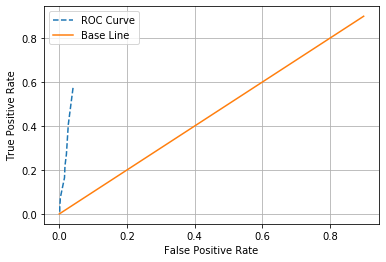

In [357]:
base=np.arange(0,1,0.1)
plt.plot(FPR,TPR,linestyle='--',label='ROC Curve')
plt.plot(base,base,label='Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()